In [2]:
%'git log'

UsageError: Line magic function `%'git` not found.


In [11]:
import pickle
import sys
import warnings

import numpy as np
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier

sys.path.append('../src/flare_classifier')
import mlprocessing as mlp


# 1. Perform preprocessing

read data
negative_class_shape (1000000, 7)
positive_class_shape (620755, 11)


Interpolate progress:   0%|          | 0/1241510 [00:00<?, ?it/s]

Interpolate data


Interpolate progress: 100%|██████████| 1241510/1241510 [06:37<00:00, 3124.69it/s]


scale data
mini rocket transform execute...
End mini rocket transform
PCA started...
PCA n_components=49 for 90% of the variance in the train data
PCA end
Create validation dataset


Interpolate progress:   0%|          | 0/1099 [00:00<?, ?it/s]

Interpolate data


Interpolate progress: 100%|██████████| 1099/1099 [00:00<00:00, 3141.29it/s]


Validation balance classes: class
0    1000
1      99
dtype: int64
List of result features (82)  ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5', 'PCA_6', 'PCA_7', 'PCA_8', 'PCA_9', 'PCA_10', 'PCA_11', 'PCA_12', 'PCA_13', 'PCA_14', 'PCA_15', 'PCA_16', 'PCA_17', 'PCA_18', 'PCA_19', 'PCA_20', 'PCA_21', 'PCA_22', 'PCA_23', 'PCA_24', 'PCA_25', 'PCA_26', 'PCA_27', 'PCA_28', 'PCA_29', 'PCA_30', 'PCA_31', 'PCA_32', 'PCA_33', 'PCA_34', 'PCA_35', 'PCA_36', 'PCA_37', 'PCA_38', 'PCA_39', 'PCA_40', 'PCA_41', 'PCA_42', 'PCA_43', 'PCA_44', 'PCA_45', 'PCA_46', 'PCA_47', 'PCA_48', 'PCA_49', 'mag_min', 'bazin_fit_rise_time', 'median_buffer_range_percentage_10', 'amplitude', 'percent_difference_magnitude_percentile_5', 'otsu_std_lower', 'eta', 'bazin_fit_reference_time', 'magnitude_percentage_ratio_40_5', 'anderson_darling_normal', 'standard_deviation', 'bazin_fit_reduced_chi2', 'otsu_lower_to_all_ratio', 'median', 'bazin_fit_fall_time', 'eta_e', 'median_absolute_deviation', 'beyond_1_std', 'skew', 'weight

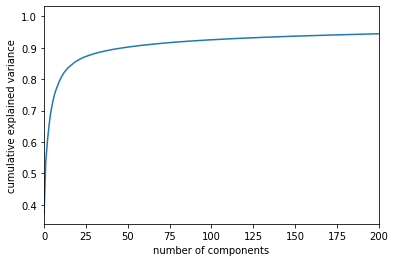

In [2]:
%%time
preprocessing_out = mlp.run_preprocessing(n_grid=100, n_samples=1_000)

# 2. Training models

In [9]:
# restore preprocessing out from files
X_train = np.loadtxt(mlp.PATH_TO_TRAIN_DATA + 'X_train.csv', delimiter=',')
X_test = np.loadtxt(mlp.PATH_TO_TRAIN_DATA + 'X_test.csv', delimiter=',')
y_train = np.loadtxt(mlp.PATH_TO_TRAIN_DATA + 'y_train.csv', delimiter=',')
y_test = np.loadtxt(mlp.PATH_TO_TRAIN_DATA + 'y_test.csv', delimiter=',')
X_val = np.loadtxt(mlp.PATH_TO_TRAIN_DATA + 'X_val.csv', delimiter=',')
y_val = np.loadtxt(mlp.PATH_TO_TRAIN_DATA + 'y_val.csv', delimiter=',')

scaler = pickle.load(open(mlp.PATH_TO_MODELS + 'scaler.pkl', 'rb'))
mini_rocket = pickle.load(
    open(mlp.PATH_TO_MODELS + 'MiniRocket_transform.pkl', 'rb')
)
pca = pickle.load(open(mlp.PATH_TO_MODELS + 'PCA.pkl', 'rb'))

## 2.1 Random forest

### 2.1.1 Grid search max_depth

In [4]:
%%time

warnings.filterwarnings('ignore')

for depth in [10, 16, 20, 24, 30, 36, 42, 48]:
    print()
    classifier = RandomForestClassifier(
        n_estimators=100, max_depth=depth, random_state=42, n_jobs=32
    )
    classifier.fit(X_train, y_train)

    y_test_proba = classifier.predict_proba(X_test)
    y_test_pred = classifier.predict(X_test)
    y_train_pred = classifier.predict(X_train)
    print(f'RandomForest classifier max_depth={depth}\n')
    df_metric = mlp.get_metric_threshold(y_test_proba, y_test)
    print('Train metrics\n')
    print(df_metric.iloc[0:2, [0, 3, 5]])

    y_val_proba = classifier.predict_proba(X_val)
    print('Validation metrics\n')
    df_metric = mlp.get_metric_threshold(y_val_proba, y_val)
    print(df_metric.iloc[0:2, [0, 3, 5]])


RandomForest classifier max_depth=10

Train metrics

              average_precision_score  F1 score count_objects
threshold=0.9                0.986074  0.814653        108118
threshold=0.8                0.986074  0.899527        131194
Validation metrics

              average_precision_score  F1 score count_objects
threshold=0.9                0.636869  0.110092            10
threshold=0.8                0.636869  0.313433            35

RandomForest classifier max_depth=16

Train metrics

              average_precision_score  F1 score count_objects
threshold=0.9                0.990639  0.875065        122377
threshold=0.8                0.990639   0.92517        137679
Validation metrics

              average_precision_score  F1 score count_objects
threshold=0.9                0.637727  0.172414            17
threshold=0.8                0.637727  0.306569            38

RandomForest classifier max_depth=20

Train metrics

              average_precision_score  F1 score count_

## 2.1.2 Learning

In [5]:
%%time

classifier = RandomForestClassifier(
    n_estimators=100, max_depth=16, random_state=42, n_jobs=32
)
classifier.fit(X_train, y_train)

pickle.dump(
    classifier, open(mlp.PATH_TO_MODELS + 'RandomForest_classifier.pkl', 'wb')
)

y_test_proba = classifier.predict_proba(X_test)
y_test_pred = classifier.predict(X_test)
print('RandomForest classifier metrics')
df_metric = mlp.get_metric_threshold(y_test_proba, y_test)
df_metric.head(10)

RandomForest classifier metrics
CPU times: user 34min 40s, sys: 8.8 s, total: 34min 49s
Wall time: 1min 24s


,average_precision_score,accuracy,ROC_AUC,F1 score,precision,count_objects,recall,f-beta score (beta=0.1),f-beta score (beta=0.3),f-beta score (beta=0.5)
threshold=0.9,0.990639,0.888355,0.99076,0.875065,0.991641,122377,0.783015,0.989032,0.970295,0.941472
threshold=0.8,0.990639,0.929441,0.99076,0.92517,0.983309,137679,0.873522,0.982087,0.973209,0.959198
threshold=0.7,0.990639,0.94508,0.99076,0.943236,0.974614,145315,0.913816,0.973972,0.969289,0.961816
threshold=0.6,0.990639,0.951859,0.99076,0.951144,0.964158,150855,0.938477,0.963896,0.961984,0.95891
threshold=0.5,0.990639,0.953779,0.99076,0.953833,0.951457,155759,0.956221,0.951504,0.951849,0.952406
threshold=0.4,0.990639,0.95105,0.99076,0.951856,0.935233,160592,0.96908,0.935557,0.937938,0.941812
threshold=0.3,0.990639,0.942989,0.99076,0.944951,0.912375,166460,0.97994,0.912999,0.917599,0.925132
threshold=0.2,0.990639,0.925117,0.99076,0.929513,0.876939,174751,0.988792,0.877922,0.885207,0.897238
threshold=0.1,0.990639,0.880858,0.99076,0.892973,0.809676,190528,0.995374,0.811175,0.822344,0.841058


## 2.1.3 Validation

In [6]:
clf = pickle.load(
    open(mlp.PATH_TO_MODELS + 'RandomForest_classifier.pkl', 'rb')
)

y_pred_proba = clf.predict_proba(X_val)

print('Metrics on validattion RandomForest classifier')
df_metric = mlp.get_metric_threshold(y_pred_proba, y_val)
df_metric.head(10)

Metrics on validattion RandomForest classifier


,average_precision_score,accuracy,ROC_AUC,F1 score,precision,count_objects,recall,f-beta score (beta=0.1),f-beta score (beta=0.3),f-beta score (beta=0.5)
threshold=0.9,0.637727,0.912648,0.96998,0.172414,0.588235,17,0.10101,0.561423,0.420687,0.299401
threshold=0.8,0.637727,0.913558,0.96998,0.306569,0.552632,38,0.212121,0.543986,0.487956,0.418327
threshold=0.7,0.637727,0.920837,0.96998,0.466258,0.59375,64,0.383838,0.590552,0.568098,0.535211
threshold=0.6,0.637727,0.939035,0.96998,0.65641,0.666667,96,0.646465,0.66646,0.664951,0.662526
threshold=0.5,0.637727,0.948135,0.96998,0.748899,0.664062,128,0.858586,0.665555,0.676722,0.695581
threshold=0.4,0.637727,0.945405,0.96998,0.761905,0.627451,153,0.969697,0.629651,0.646285,0.675105
threshold=0.3,0.637727,0.923567,0.96998,0.697842,0.541899,179,0.979798,0.544308,0.562663,0.595092
threshold=0.2,0.637727,0.878981,0.96998,0.595745,0.426087,230,0.989899,0.428503,0.447114,0.480864
threshold=0.1,0.637727,0.784349,0.96998,0.455172,0.294643,336,1.0,0.296715,0.312864,0.343035


## 2.2 Catboost

## 2.2.2 Learning

In [10]:
%%time

model = mlp.CatBoostClassifierCalibrate(
    iterations=5_000,
    learning_rate=0.01,
    depth=10,
    early_stopping_rounds=20,
    random_seed=42,
)

model.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    verbose=100,
)

pickle.dump(model, open(mlp.PATH_TO_MODELS + 'Catboost_classifier.pkl', 'wb'))

y_test_proba = model.predict_proba(X_test)
print('Catboost classifier')
df_metric = mlp.get_metric_threshold(y_test_proba, y_test)
df_metric.head(10)

0:	learn: 0.6758883	test: 0.6759438	best: 0.6759438 (0)	total: 271ms	remaining: 22m 33s
100:	learn: 0.1940114	test: 0.1954162	best: 0.1954162 (100)	total: 15.7s	remaining: 12m 43s
200:	learn: 0.1486699	test: 0.1504610	best: 0.1504610 (200)	total: 30.9s	remaining: 12m 16s
300:	learn: 0.1330074	test: 0.1352528	best: 0.1352528 (300)	total: 46.2s	remaining: 12m
400:	learn: 0.1242102	test: 0.1269263	best: 0.1269263 (400)	total: 1m 1s	remaining: 11m 46s
500:	learn: 0.1177722	test: 0.1209396	best: 0.1209396 (500)	total: 1m 17s	remaining: 11m 34s
600:	learn: 0.1128045	test: 0.1164332	best: 0.1164332 (600)	total: 1m 32s	remaining: 11m 19s
700:	learn: 0.1086949	test: 0.1127971	best: 0.1127971 (700)	total: 1m 48s	remaining: 11m 4s
800:	learn: 0.1052102	test: 0.1097697	best: 0.1097697 (800)	total: 2m 3s	remaining: 10m 48s
900:	learn: 0.1023344	test: 0.1073780	best: 0.1073780 (900)	total: 2m 19s	remaining: 10m 33s
1000:	learn: 0.0998218	test: 0.1053033	best: 0.1053033 (1000)	total: 2m 34s	remaining

,average_precision_score,accuracy,ROC_AUC,F1 score,precision,count_objects,recall,f-beta score (beta=0.1),f-beta score (beta=0.3),f-beta score (beta=0.5)
threshold=0.9,0.99556,0.939551,0.995723,0.936061,0.99194,138453,0.886142,0.990768,0.982256,0.968806
threshold=0.8,0.99556,0.958721,0.995723,0.957465,0.986125,146229,0.930425,0.98554,0.981274,0.974457
threshold=0.7,0.99556,0.965668,0.995723,0.965096,0.980082,150315,0.950562,0.979781,0.977575,0.974032
threshold=0.6,0.99556,0.96869,0.995723,0.968483,0.973617,153357,0.963402,0.973515,0.972766,0.971557
threshold=0.5,0.99556,0.969186,0.995723,0.969237,0.966371,155905,0.97212,0.966427,0.966843,0.967515
threshold=0.4,0.99556,0.968132,0.995723,0.968432,0.958154,158344,0.978933,0.958356,0.959837,0.962239
threshold=0.3,0.99556,0.964888,0.995723,0.965533,0.946905,161203,0.984908,0.947267,0.949932,0.95427
threshold=0.2,0.99556,0.957694,0.995723,0.95897,0.929719,165052,0.990121,0.930281,0.934426,0.941203
threshold=0.1,0.99556,0.941848,0.995723,0.944717,0.89922,171502,0.995064,0.900078,0.906429,0.916883


## 2.2 Validation

In [11]:
clf = pickle.load(open(mlp.PATH_TO_MODELS + 'Catboost_classifier.pkl', 'rb'))

y_pred_proba = clf.predict_proba(X_val)

print('Metrics on validattion Catboost classifier')
df_metric = mlp.get_metric_threshold(y_pred_proba, y_val)
df_metric.head(10)

Metrics on validattion Catboost classifier


,average_precision_score,accuracy,ROC_AUC,F1 score,precision,count_objects,recall,f-beta score (beta=0.1),f-beta score (beta=0.3),f-beta score (beta=0.5)
threshold=0.9,0.837739,0.953594,0.971091,0.690909,0.863636,66,0.575758,0.859382,0.829395,0.785124
threshold=0.8,0.837739,0.953594,0.971091,0.718232,0.792683,82,0.656566,0.791059,0.779342,0.761124
threshold=0.7,0.837739,0.956324,0.971091,0.75,0.774194,93,0.727273,0.773699,0.770091,0.764331
threshold=0.6,0.837739,0.953594,0.971091,0.746269,0.735294,102,0.757576,0.735508,0.737084,0.739645
threshold=0.5,0.837739,0.955414,0.971091,0.767773,0.723214,112,0.818182,0.724046,0.730213,0.740402
threshold=0.4,0.837739,0.941765,0.971091,0.716814,0.637795,127,0.818182,0.639191,0.649621,0.667216
threshold=0.3,0.837739,0.940855,0.971091,0.73251,0.618056,144,0.89899,0.619974,0.634425,0.659259
threshold=0.2,0.837739,0.932666,0.971091,0.708661,0.580645,155,0.909091,0.58273,0.598499,0.625869
threshold=0.1,0.837739,0.899909,0.971091,0.630872,0.472362,199,0.949495,0.474724,0.492809,0.52514


# 3. Analisys results 

In [12]:
print(f'x_val.shape = {X_val.shape}')
print(f'X_train.shape = {X_train.shape}')

x_val.shape = (1099, 82)
X_train.shape = (931132, 82)


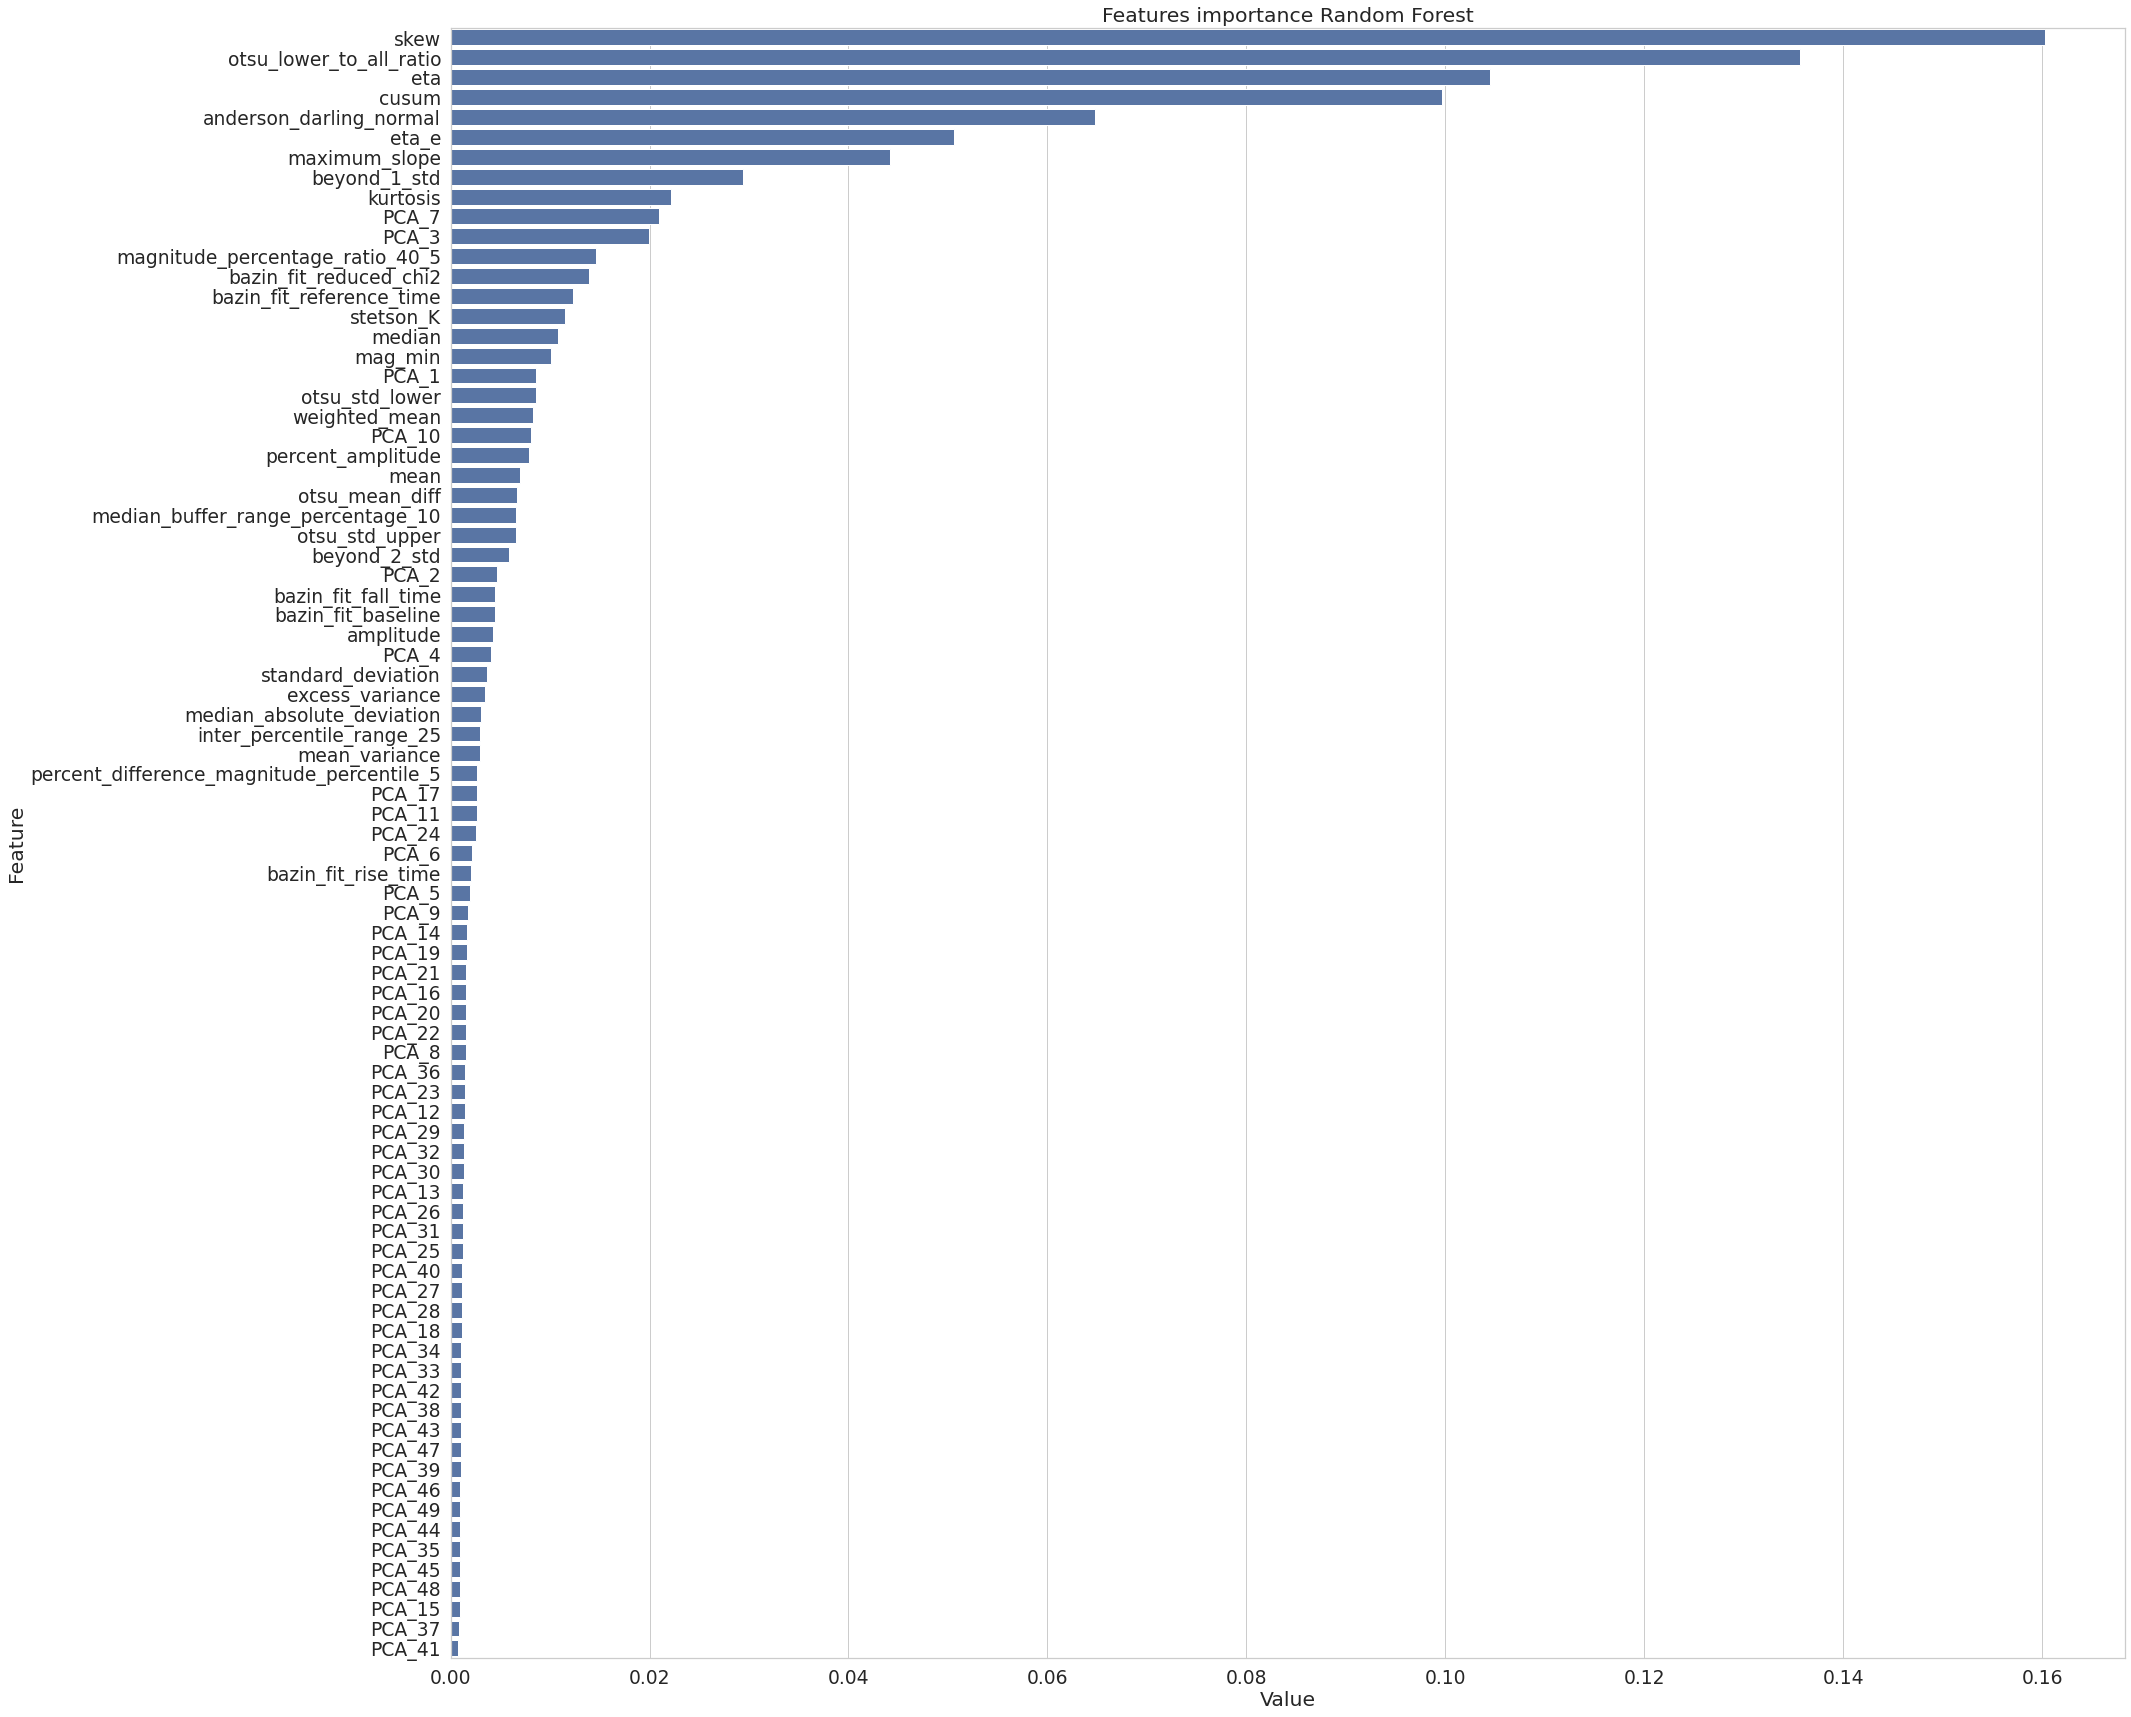

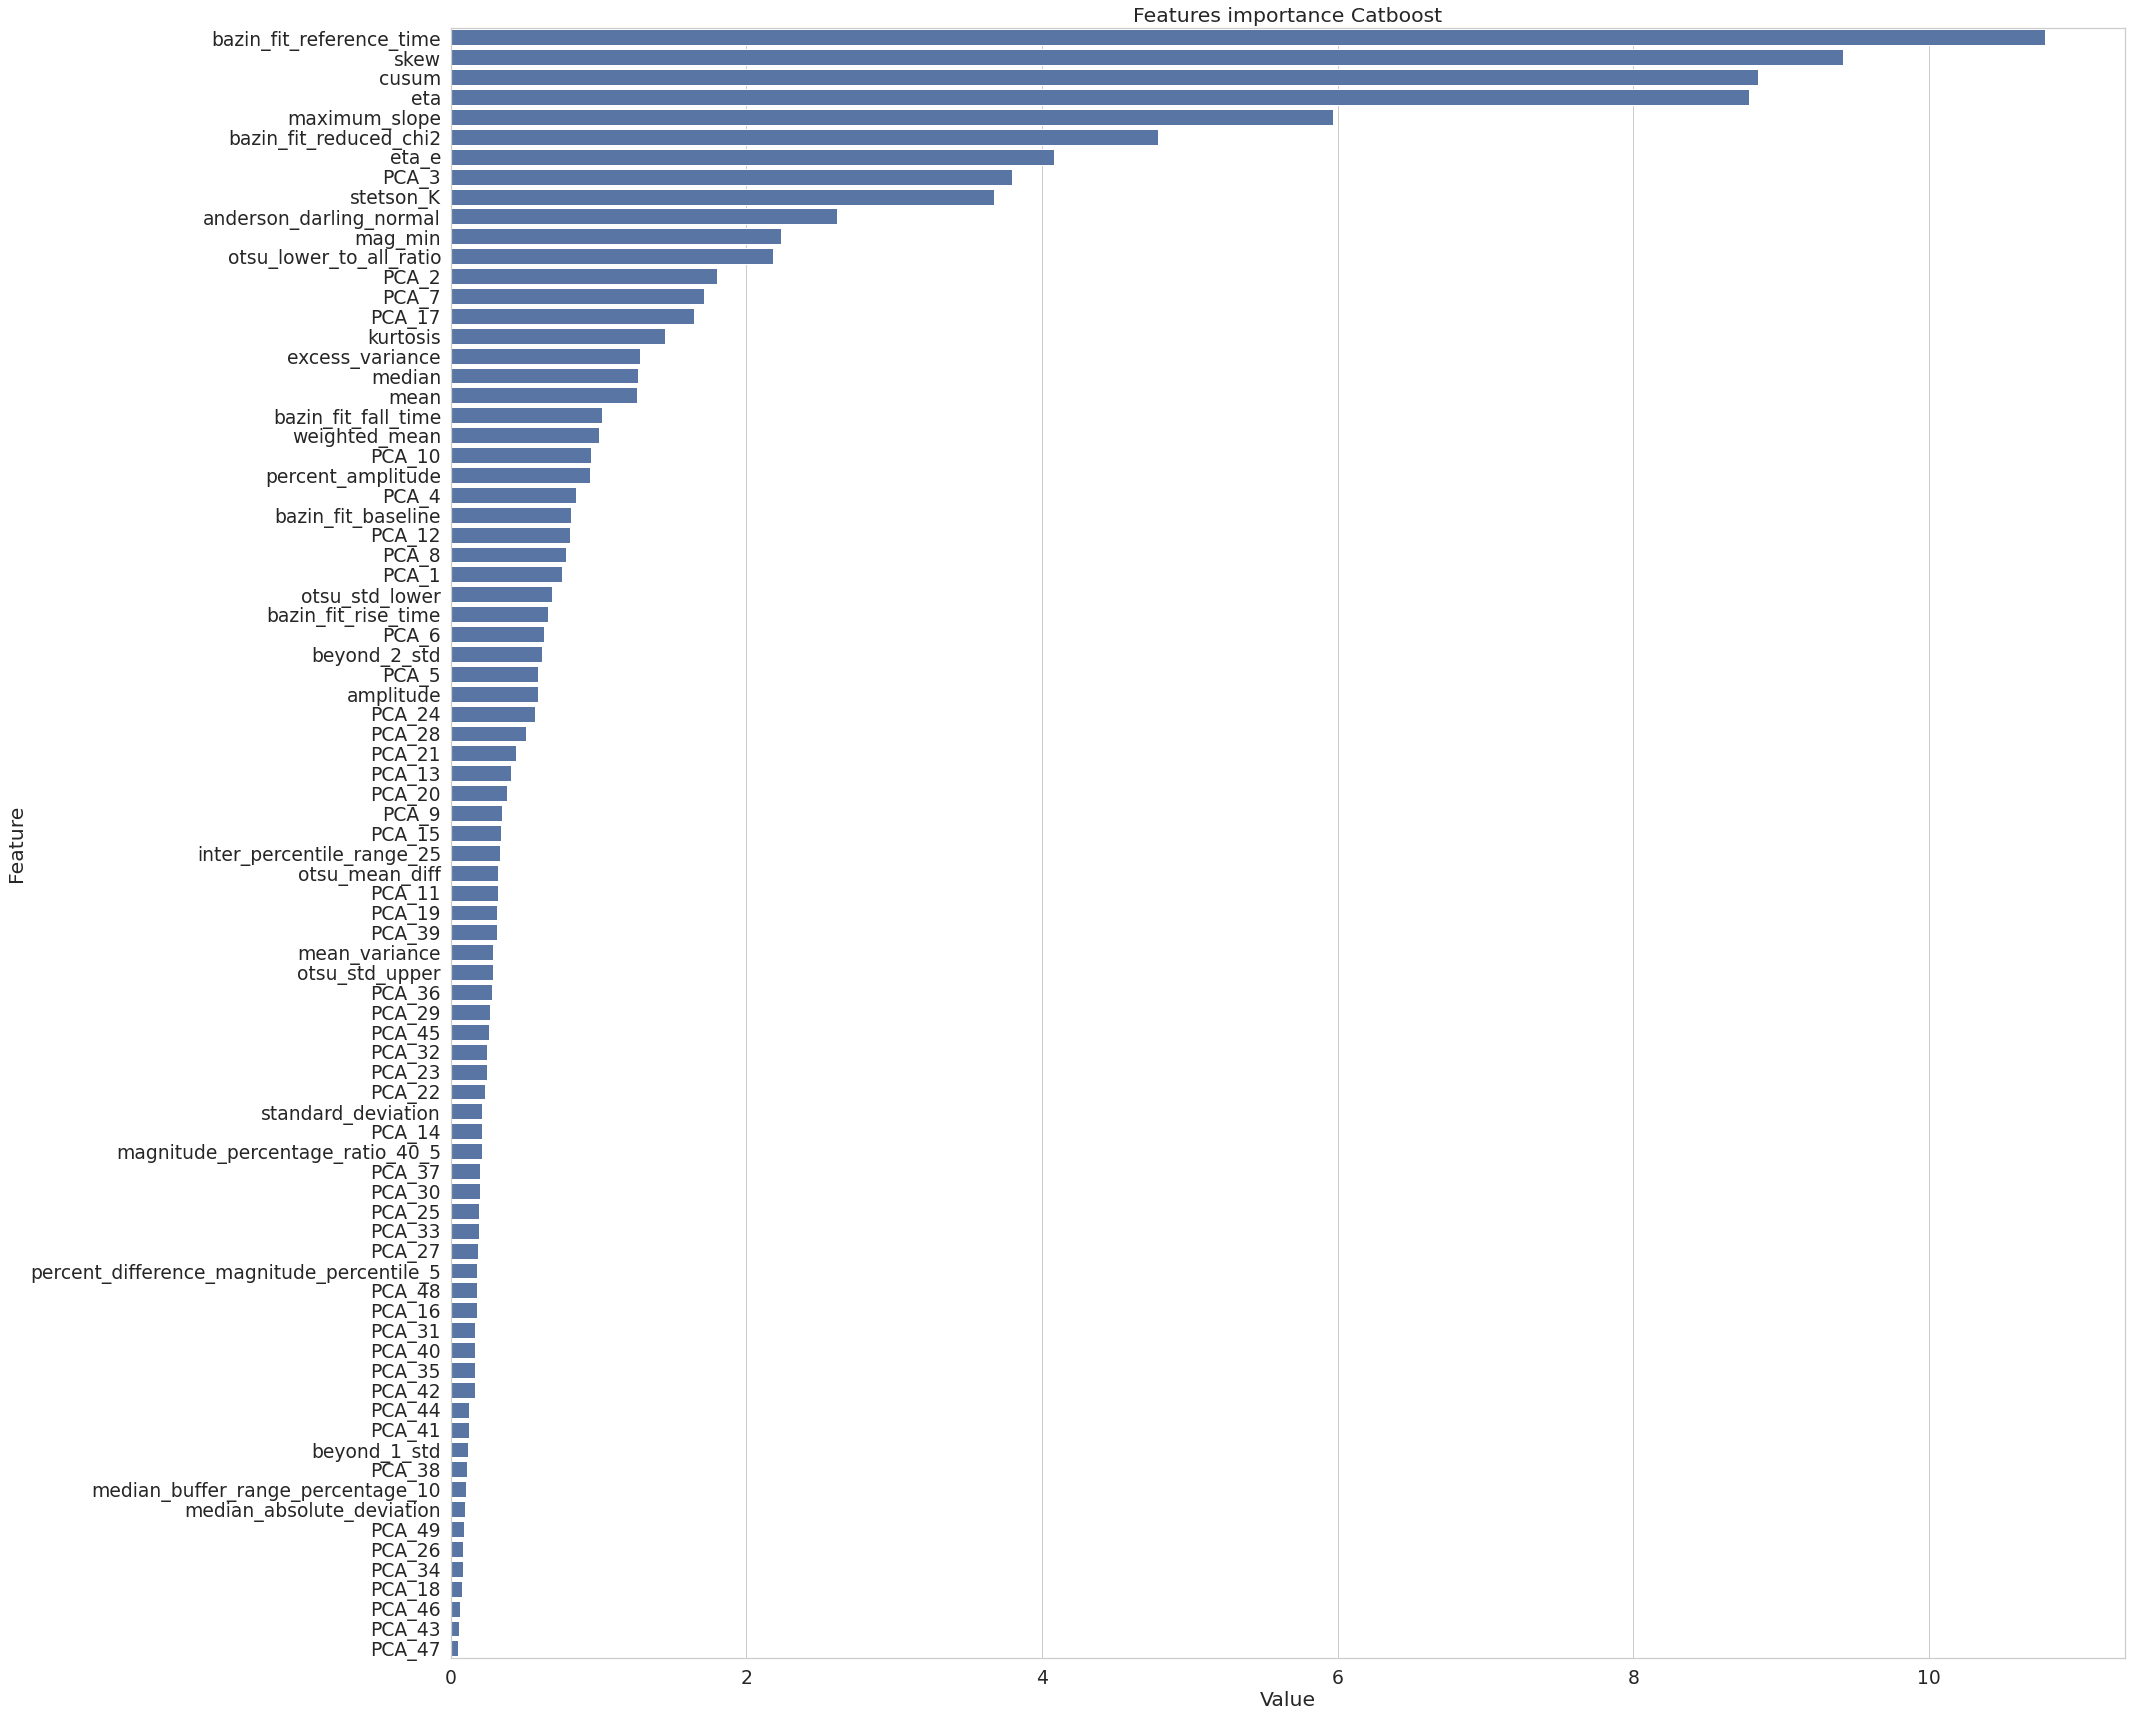

In [13]:
warnings.filterwarnings('ignore')


def plot_feature_impotance(coefficients, columns, title):
    """Plot feature impotance diagramm

    Args:
        coefficients (list): model coefficients
        columns (list): list of features
        title (str): title of plot
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    feature_imp = pd.DataFrame({'Value': coefficients, 'Feature': columns})
    feature_imp = feature_imp.sort_values(by='Value', ascending=False)
    plt.figure(figsize=(30, 30))
    sns.set(font_scale=5)
    sns.set(style='whitegrid', color_codes=True, font_scale=1.7)
    sns.barplot(x='Value', y='Feature', data=feature_imp)
    plt.title(title)
    plt.show()


features_list = pickle.load(
    open(mlp.PATH_TO_MODELS + 'features_list.pkl', 'rb')
)

rf = pickle.load(open(mlp.PATH_TO_MODELS + 'RandomForest_classifier.pkl', 'rb'))
catboost = pickle.load(
    open(mlp.PATH_TO_MODELS + 'Catboost_classifier.pkl', 'rb')
)

plot_feature_impotance(
    rf.feature_importances_, features_list, 'Features importance Random Forest'
)
plot_feature_impotance(
    catboost.feature_importances_, features_list, 'Features importance Catboost'
)

# 4. Calibration of classifiers

In [14]:
%%time

rf = pickle.load(open(mlp.PATH_TO_MODELS + 'RandomForest_classifier.pkl', 'rb'))
catboost = pickle.load(
    open(mlp.PATH_TO_MODELS + 'Catboost_classifier.pkl', 'rb')
)

rf_isotonic = CalibratedClassifierCV(rf, cv='prefit', method='isotonic')
catboost_isotonic = CalibratedClassifierCV(
    catboost, cv='prefit', method='isotonic'
)

clf_list = [
    (rf, 'RandomForest'),
    (catboost, 'Catboost'),
    (rf_isotonic, 'RandomForestIsotonic'),
    (catboost_isotonic, 'CatboostIsotonic'),
]

calibrated_models = clf_list[-2:]

for model, name in calibrated_models:
    print(f'Calibtating {model}...')
    model.fit(X_test, y_test)
    pickle.dump(
        model, open(mlp.PATH_TO_MODELS + f'calibrated_{name}.pkl', 'wb')
    )

Calibtating CalibratedClassifierCV(cv='prefit',
                       estimator=RandomForestClassifier(max_depth=16, n_jobs=32,
                                                        random_state=42),
                       method='isotonic')...
Calibtating CalibratedClassifierCV(cv='prefit',
                       estimator=<__main__.CatBoostClassifierCalibrate object at 0x7fe8f16ac8b0>,
                       method='isotonic')...
CPU times: user 19.9 s, sys: 1.24 s, total: 21.2 s
Wall time: 4.7 s


In [15]:
def plot_calibration_curve(clf_list, title):
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec

    fig = plt.figure(figsize=(20, 20))
    gs = GridSpec(4, 3)
    colors = plt.get_cmap('Dark2')

    ax_calibration_curve = fig.add_subplot(gs[:2, :3])
    calibration_displays = {}
    for i, (clf, name) in enumerate(clf_list):
        display = CalibrationDisplay.from_estimator(
            clf,
            X_test,
            y_test,
            n_bins=10,
            name=name,
            ax=ax_calibration_curve,
            color=colors(i),
        )
        calibration_displays[name] = display

    ax_calibration_curve.grid()
    ax_calibration_curve.set_title(title)

    # Add histogram
    grid_positions = [(2, 0), (2, 1), (2, 2)]
    for i, (_, name) in enumerate(clf_list):
        row, col = grid_positions[i]
        ax = fig.add_subplot(gs[row, col])

        ax.hist(
            calibration_displays[name].y_prob,
            range=(0, 1),
            bins=10,
            label=name,
            color=colors(i),
        )
        ax.set(title=name, xlabel='Mean predicted probability', ylabel='Count')

    plt.tight_layout()
    plt.show()

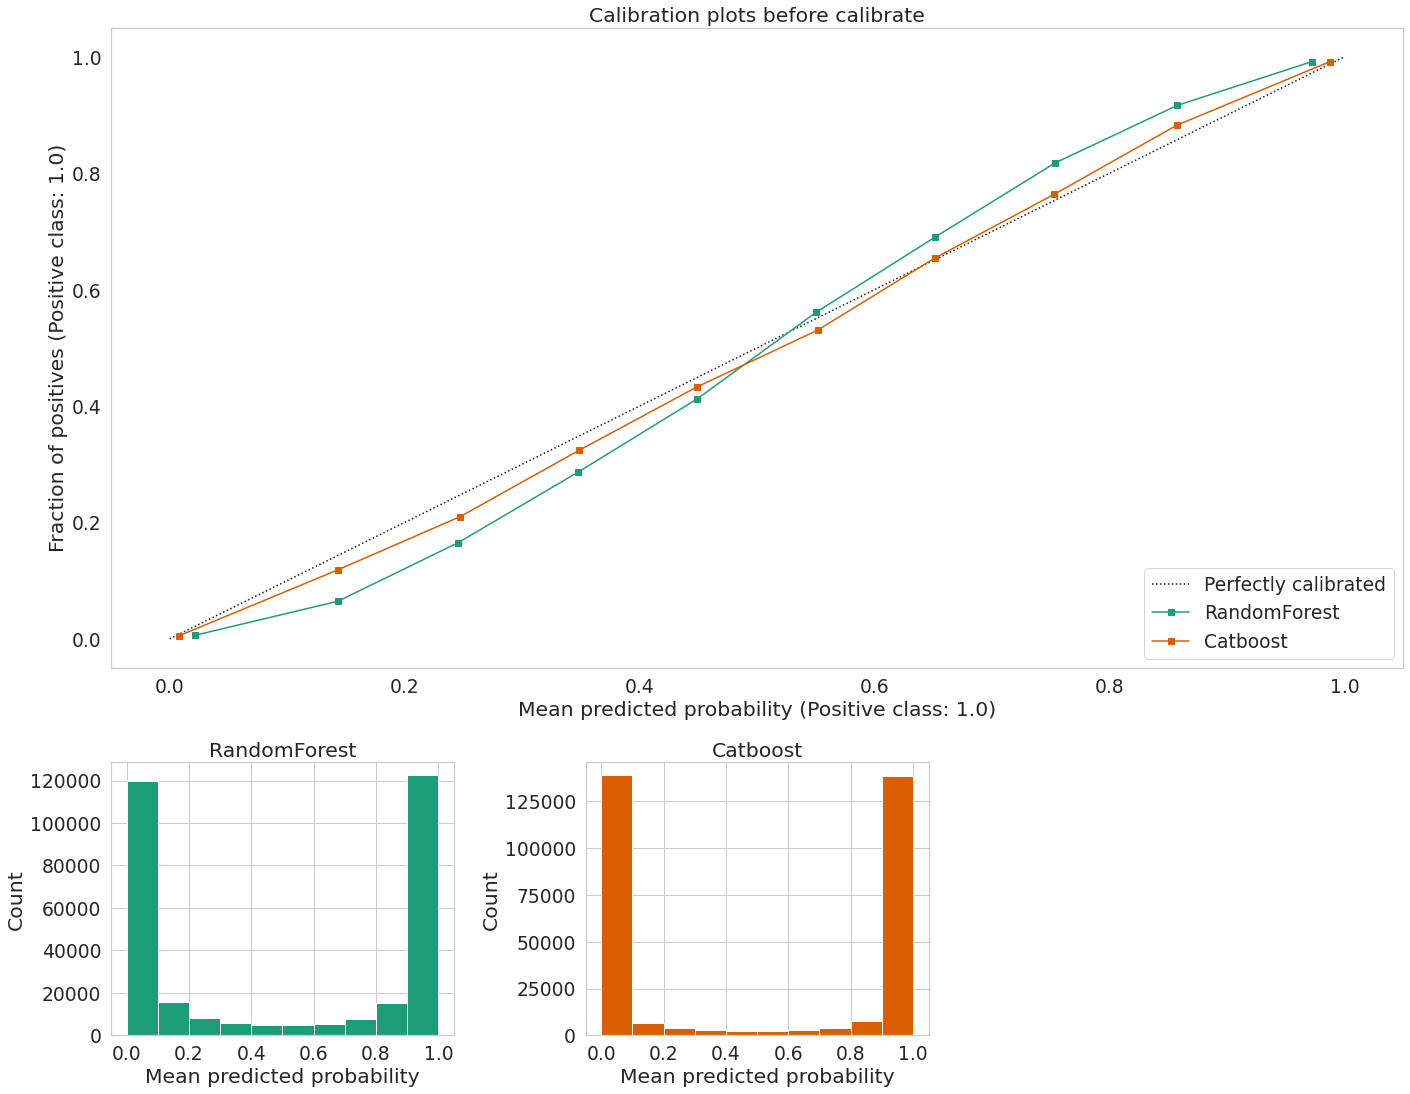

In [16]:
plot_calibration_curve(
    clf_list[:-2], title='Calibration plots before calibrate'
)

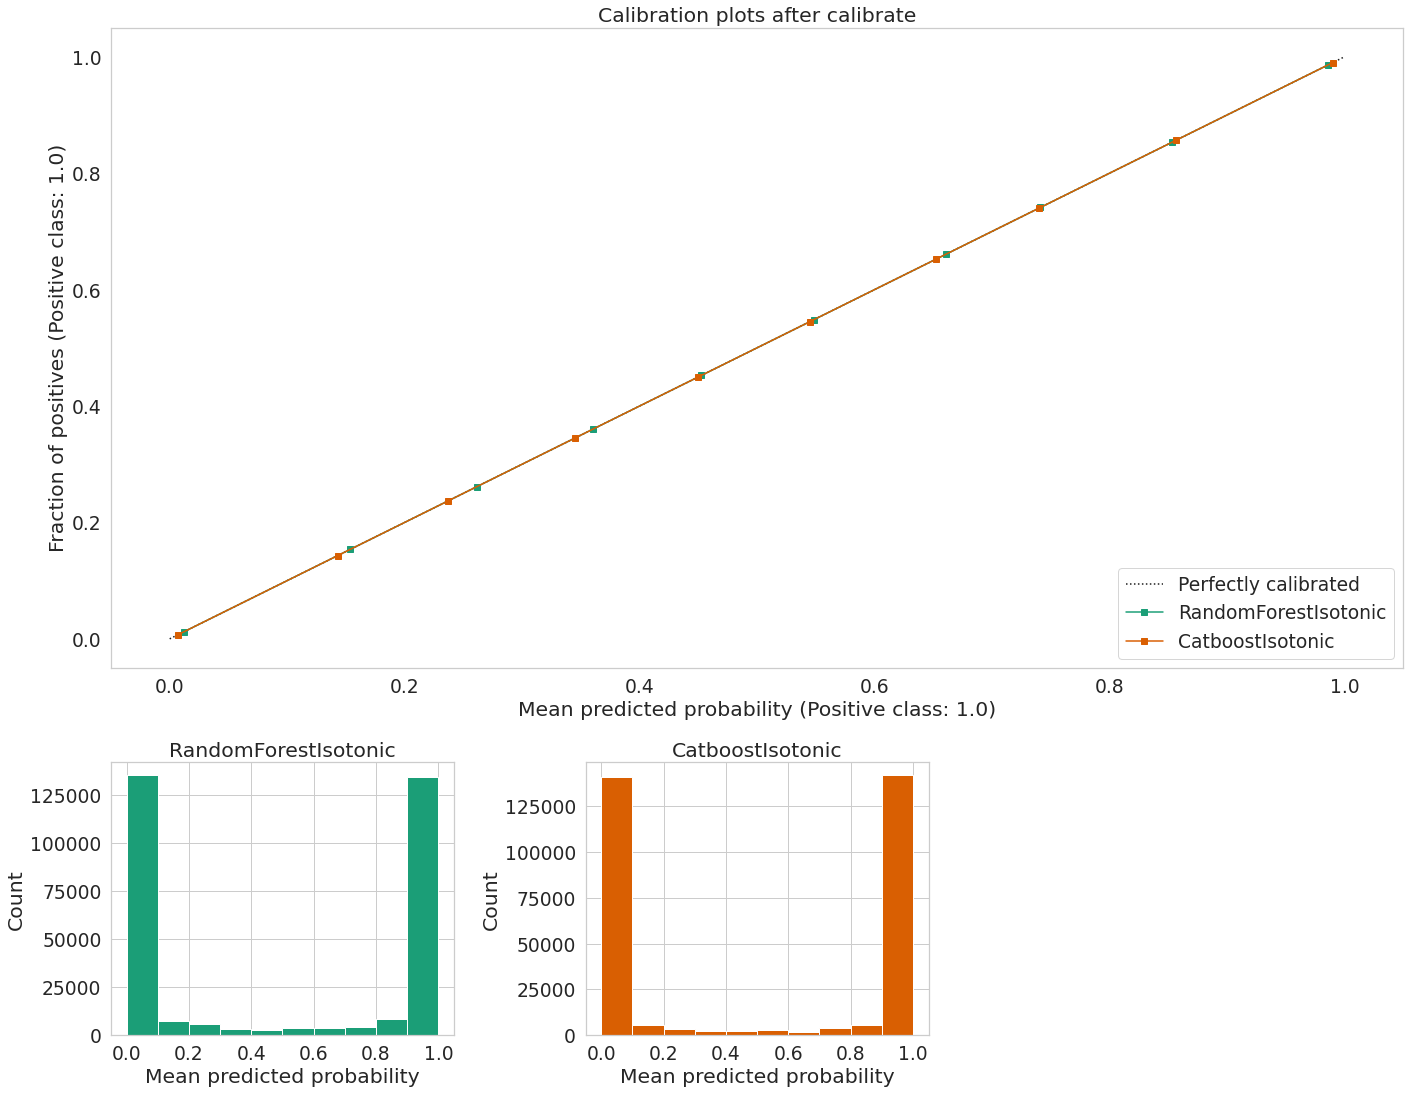

In [17]:
plot_calibration_curve(clf_list[-2:], title='Calibration plots after calibrate')